In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve


In [3]:
# Load the dataset 
data = pd.read_csv(r"C:\Users\swast\OneDrive\Desktop\fraudtransaction\Fraud.csv")


# first few rows
print(data.head())

# Check the shape 
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

# data types and missing values
print(data.info())

# Check for missing values
print(f"Missing values per column:\n{data.isnull().sum()}")

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
The dataset has 6362620 rows and 11 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 en

In [4]:
#Impute missing values with 'Unknown' for 'nameDest' and 0 for balance columns
data['nameDest'] = data['nameDest'].fillna('Unknown')
data['oldbalanceDest'] = data['oldbalanceDest'].fillna(0)
data['newbalanceDest'] = data['newbalanceDest'].fillna(0)

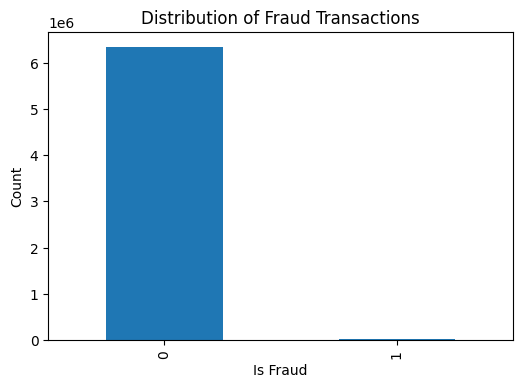

In [5]:
plt.figure(figsize=(6, 4))
data['isFraud'].value_counts().plot(kind='bar')
plt.title('Distribution of Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

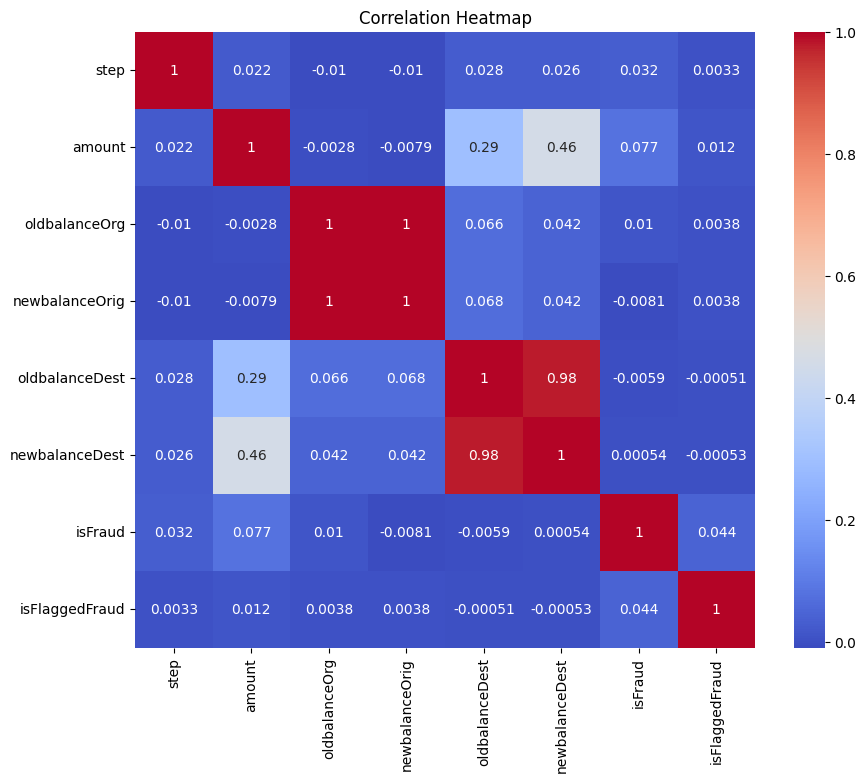

In [19]:
# Label 'nameOrig' and 'nameDest' columns
data['nameOrig'] = data['nameOrig'].astype('category').cat.codes
data['nameDest'] = data['nameDest'].astype('category').cat.codes

numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

corr_matrix = data[numeric_cols].corr()

# correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [36]:
X = data[[ 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceDest', 'nameOrig', 'nameDest']]
y = data['isFraud']

In [37]:
pca = PCA(n_components=0.9)  

# Fit and transform the data
X_pca = pca.fit_transform(X)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)

X_transformed = pca.inverse_transform(X_pca)

Explained variance ratio: [0.66010059 0.2208512  0.08925618]


In [38]:
X_transformed = X_pca
X_selected = X
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [34]:
# XGBoost -> implementation of the gradient boosting decision tree algorithm
# builds an ensemble of weak decision tree models in a sequential manner, correct the errors made by the previous trees
# Handling Imbalanced Data, Interpretability, Handling Mixed Data Type, Robustness to Outliers, High Predictive Performance, Parallelization and Scalability
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [39]:
params = {
    'objective': 'binary:logistic',  # For binary classification
    'max_depth': 3,  # Maximum depth of the decision trees
    'eta': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of the training data
    'colsample_bytree': 0.7  # Subsample ratio of columns for each tree
}

In [40]:
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

In [41]:
# Make predictions
y_pred = model.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred]  # Convert to binary labels

# Evaluate performance
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Precision: 0.9392
Recall: 0.3432
F1-Score: 0.5027
AUC-ROC: 0.6716


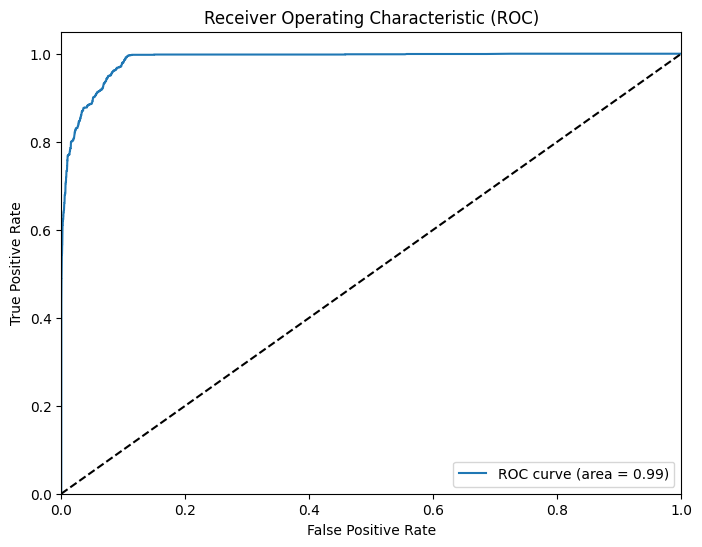

In [42]:
y_prob = model.predict(dtest)
# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Get feature importances
feature_importances = model.get_score(importance_type='gain')
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance:.4f}")

amount: 259.7690
oldbalanceOrg: 487.5260
oldbalanceDest: 280.7913
newbalanceDest: 440.5881
nameDest: 222.5840


Account balances (oldbalanceOrg, oldbalanceDest, newbalanceDest) can help identify unusual or suspicious changes that may indicate fraud.
Transaction amounts (amount) are a fundamental aspect of financial transactions, and fraudulent activities often exhibit anomalous patterns in transaction amounts.
Recipient account information (nameDest) can help identify accounts or entities that may be associated with fraudulent activities or money laundering schemes.

Model Backup and Version Control
Testing Models in Staging Environment
Performance Monitoring - continuous alert system
Model Retraining
Data Pipeline Validation

Monitoring and Logging
Data Integrity Checks
Model Performance Evaluation
Feedback and Testing